In [1]:
!source bin/activate

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
songs = pd.read_csv('data/songs.csv')
songs_meta = pd.read_csv('data/song_extra_info.csv')
users = pd.read_csv('data/members.csv')

In [4]:
train.shape, test.shape, songs.shape, songs_meta.shape, users.shape

((7377418, 6), (2556790, 6), (2296320, 7), (2295971, 3), (34403, 7))

# Data Quality
We start by looking at the quality of data in each of the tables, for each of the features. The height of the bar indicates the percentage of null/unknown values in each of the features

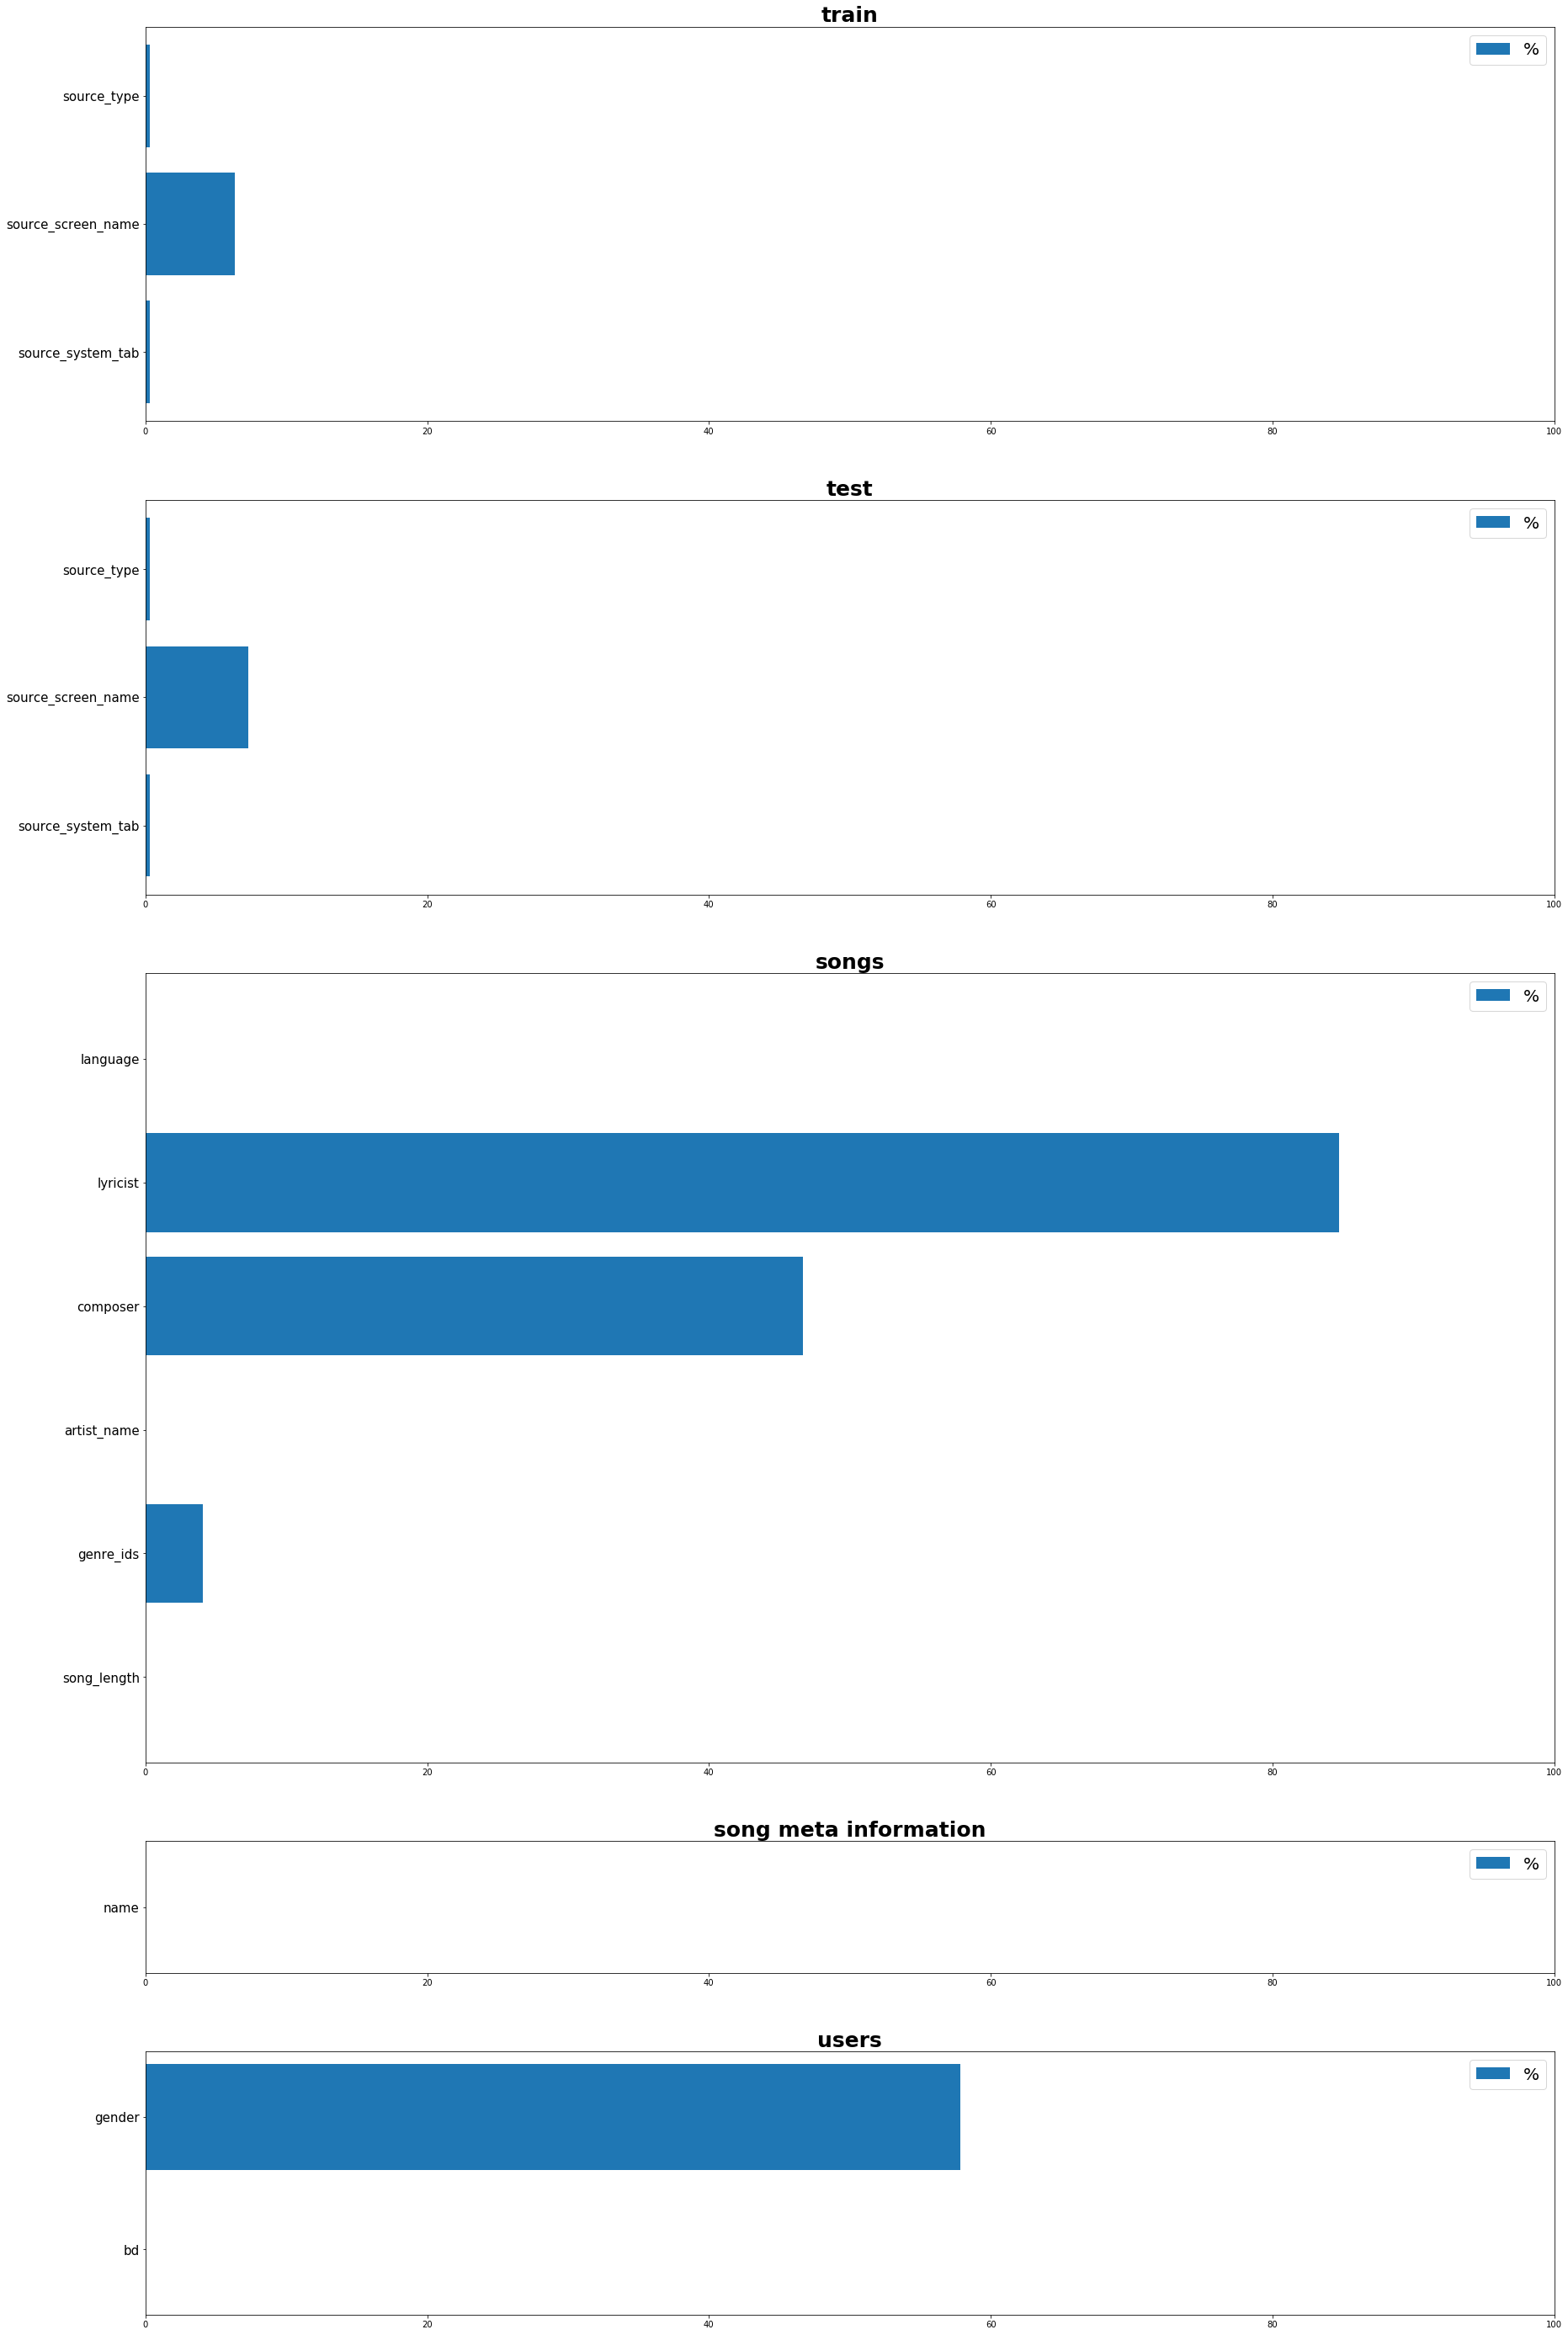

In [5]:
def plot_null_distribution(ax, table, columns, filters, name):
    count = table.shape[0]
    values = []
    
    for (i, col) in enumerate(columns):
        count_f = sum(table[col].isnull())
        for f in filters[i]:
            count_f += sum(table[col] == f)
        values.append(100*count_f/float(count))
        
    n = len(columns)
    p = ax.barh(range(n), values)
    ax.set_title(name, fontdict={'fontsize': 25, 'fontweight': 'bold'})
    ax.set_yticks(range(n))
    ax.set_yticklabels(columns, size=15)
    ax.set_xlim(0, 100)
    ax.legend('% missing/unknown', fontsize=20)

fg, axes = plt.subplots(5, 1, figsize=(30, 50), gridspec_kw  = {"height_ratios": [3, 3, 6, 1, 2]})
plot_null_distribution(axes[0], train, ['source_system_tab', 'source_screen_name', 'source_type'],
                       [['null'], ['Unknown'], []], 'train')

plot_null_distribution(axes[1], test, ['source_system_tab', 'source_screen_name', 'source_type'],
                       [['null'], ['Unknown'], []], 'test')

plot_null_distribution(axes[2], songs, ['song_length', 'genre_ids', 'artist_name',
                                        'composer', 'lyricist', 'language'],
                       [[], [], [], [], [], []], 'songs')

plot_null_distribution(axes[3], songs_meta, ['name'],
                       [['unknown', 'Unknown']], 'song meta information')
                        
plot_null_distribution(axes[4], users, ['bd', 'gender'],
                       [[], []], 'users')                

# Class Statistics

We start by looking at all the features, the class distributions and the class distribution by each feature

### Feature distribution
We first look into the distribution of different features.

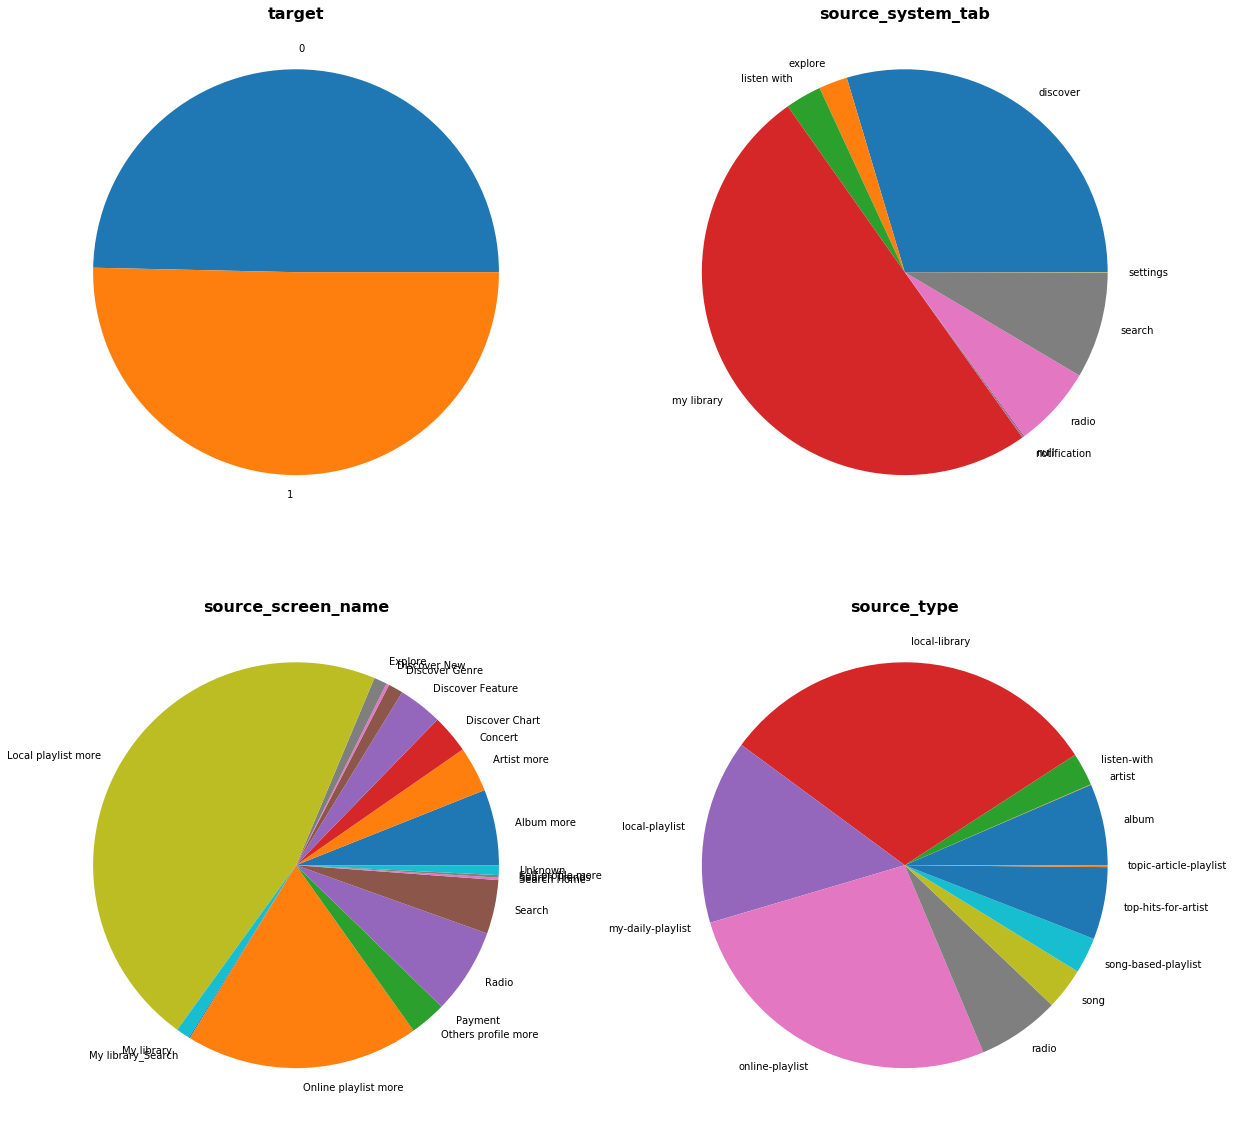

In [6]:
def plot_distribution(col, ax):
    groupby = train.groupby(col)[col].count()
    labels= groupby.keys()
    values = groupby.values
    ax.axis('equal')
    ax.pie(values, labels=labels)
    ax.set_title(col, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    
fg, axes = plt.subplots(2, 2, figsize=(20, 20))

plot_distribution('target', axes[0, 0])
plot_distribution('source_system_tab', axes[0, 1])
plot_distribution('source_screen_name', axes[1, 0])
plot_distribution('source_type', axes[1, 1])

### Factors affecting class distribution
Here, we look at how each of the features affects the distribution of the target variables. We will look at histograms, with each column corresponding to a value of the feature. The height is proportional to the raw count of the feature values.

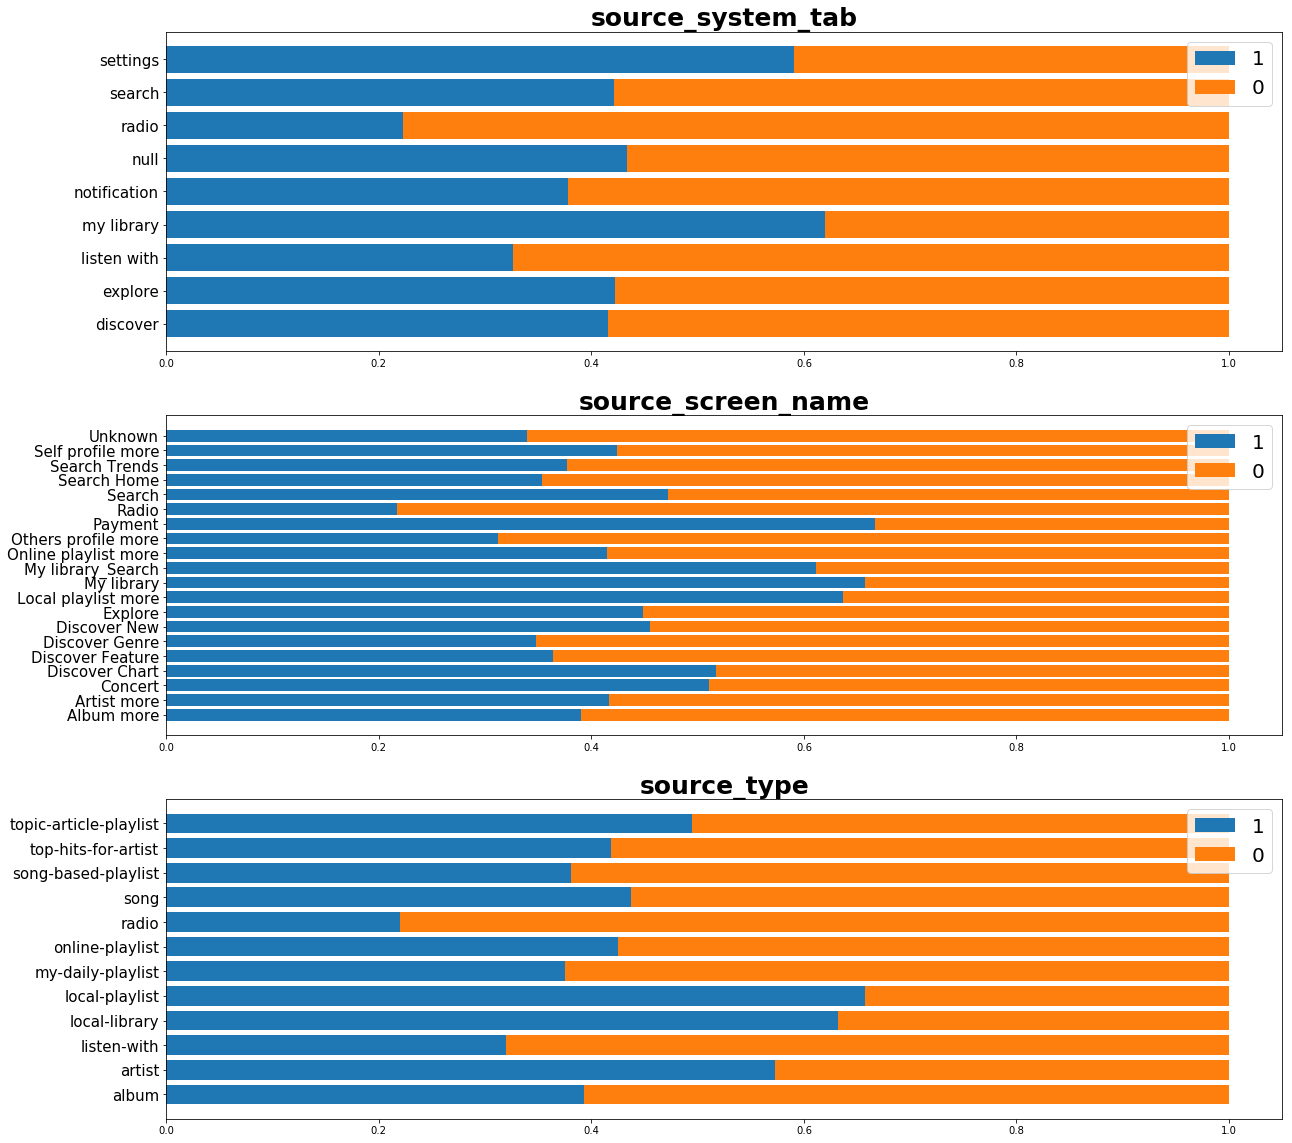

In [7]:
def plot_predictive_power(ax, col):
    t = train.groupby([col, 'target']).size().reset_index(name='counts')
    labels = t[col].unique()
    positive = t['counts'][t['target']==1].values
    negative = t['counts'][t['target']==0].values
    total = positive+negative
    positive, negative = positive/total, negative/total

    n = labels.shape[0]
    p1 = ax.barh(range(n), positive)
    p2 = ax.barh(range(n), negative, left = positive)
    ax.set_title(col, fontdict={'fontsize': 25, 'fontweight': 'bold'})
    ax.set_yticks(range(n))
    ax.set_yticklabels(labels, size=15)
    ax.legend((p1[0], p2[0]), (1, 0), fontsize=20)
    
fg, axes = plt.subplots(3, 1, figsize=(20, 20))
plot_predictive_power(axes[0], 'source_system_tab')
plot_predictive_power(axes[1], 'source_screen_name')
plot_predictive_power(axes[2], 'source_type')

As we would expect, a song which is played from local playlist is listened to again more than 60% of the time. Whereas those heard from the radio have the least (20%) likely to be listened to again. An interesting feature of KKBox, "listen with" allows the user to listen to a song a friend or a celebrity is listening to while chatting with them. Songs introduced to the user via "listen with" are repeated only 30% of the time

# Song Statistics

We now look at the songs and songs_meta tables. We start by looking into the different columns present in the songs table

In [58]:
pd.Series(songs.artist_name.sort_values(inplace=False).unique())[:30]

0      2 THE EXTREME,Master Chief & iLLest Game,,52\...
1      2 THE EXTREME,Master Chief & iLLest Game,,52\...
2                                                 !Conz
3                                            !Creekside
4                                             !Dela Dap
5                                                 !Dris
6                                              !Estevan
7                                            !Fuckyeah!
8                               !NTELLIGENT Electro Pop
9                          !Ntell!Gent Des!Gn| DJ Shoba
10                                                  !a!
11                                             !distain
12                                              !llmind
13                                             !magnic!
14                                          !mindparade
15                                                #####
16                                                   #$
17                              #01.A.1948 (#01.

There are lots of values in the artist_name column which are very similar to each other. For example, the first two values actually refer to the same entity. Therefore, in order to denoise the artist names, we need to find a good way of mapping these different variations of the same entity into a unique entity. Similarly, we might want to check other columns as well

In [9]:
pd.Series(songs.composer.sort_values(inplace=False).unique())[:20]

0                                                 伍樂城
1                                              \tBEGIN
2                                               \tmaya
3                                                \tゆきみ
4                                   \tエドワード･ウィリアム・エルガー
5                                               \t加藤裕介
6                                               \t村井邦彦
7                                       \tＳＨＯＴＡ　ＫＡＮＥＫＯ
8                                                     
9                                           A Hawkshaw
10                                       Alan Hawkshaw
11                                  Andre Tanneberger 
12                Anna Lidner+Charles Kwashie tamakloe
13                          Bach arr. Jonathan Starkey
14                                        Bill Le Sage
15                         Bill Martin / Phil Coulter 
16                                              C Hall
17     Chinese Lyrics by 黄贞颖 Annakid (0%) Kim Jin Hwan
18        

Similarly, we see tat a lot of artist names have been combined using | symbol. Mixed cases, and the '\t' character in the beginning all contribute to minor variations in the names of each entity. Another example - "A Hawkshaw" vs "Alan Hawkshaw". Can we use some automated way, such as wikipedia, google or a pretrained NER system to normalize these entities?

In [10]:
pd.Series(songs.lyricist.sort_values(inplace=False).unique())[:20]

0                                                      
1                             Al Stillman|Robert Allen 
2                                            Bank Clash
3                         Bruno Martino|Bruno Brighetti
4                                             Don Black
5                                        HIROAKI HAYAMA
6                                             Ivan Lins
7      Korean Lyrics by 100%SEOJUNG (12.5%) Albi Alb...
8      Korean Lyrics by Cho| Yun Kyoung (12.5%) Albi...
9      Korean Lyrics by Cho| Yun Kyoung (12.5%) Comm...
10     Korean Lyrics by Cho| Yun Kyoung (12.5%) Paul...
11     Korean Lyrics by Cho| Yun Kyoung (5%) / Janua...
12     Korean Lyrics by JQ (3%) / Seo Lim (8%) / Gi|...
13     Korean Lyrics by JQ (4.5%) / Seo Lim (3%) / C...
14     Korean Lyrics by Kim| Ea Na (10%) / MC META (...
15     Korean Lyrics by Kim| In Hyeong (12.5%) Andre...
16     Korean Lyrics by Kim| In Hyeong (12.5%) Will ...
17     Korean Lyrics by Kim| Jong Hyun (12.5%) G

Same is the issue with lyricst column. Morevoer, as we see from the data quality graphs, lyricist and composer columns have lots of missing data. Maybe we can discard these two columns initially and use it later when we are looking to boost the accuracy scores

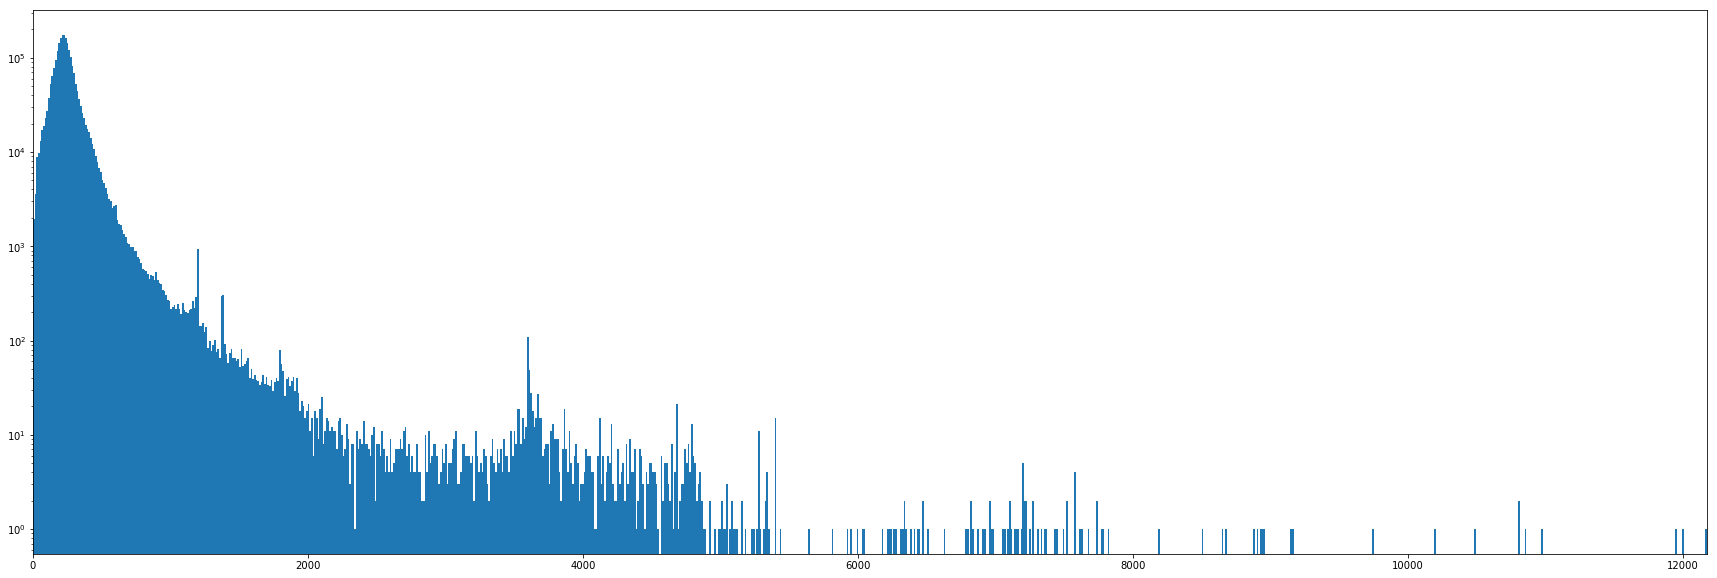

In [11]:
plt.figure(figsize=(30, 10))
song_lengths = songs.song_length.sort_values(inplace=False)/1000.0
plt.hist(song_lengths, bins=1000)
plt.xlim(0, max(song_lengths))
plt.yscale('log')

Now this looks interesting. Notice the standalone towers after 3000, these are caused by extraordinarily long songs. Might be a good idea to clip them?

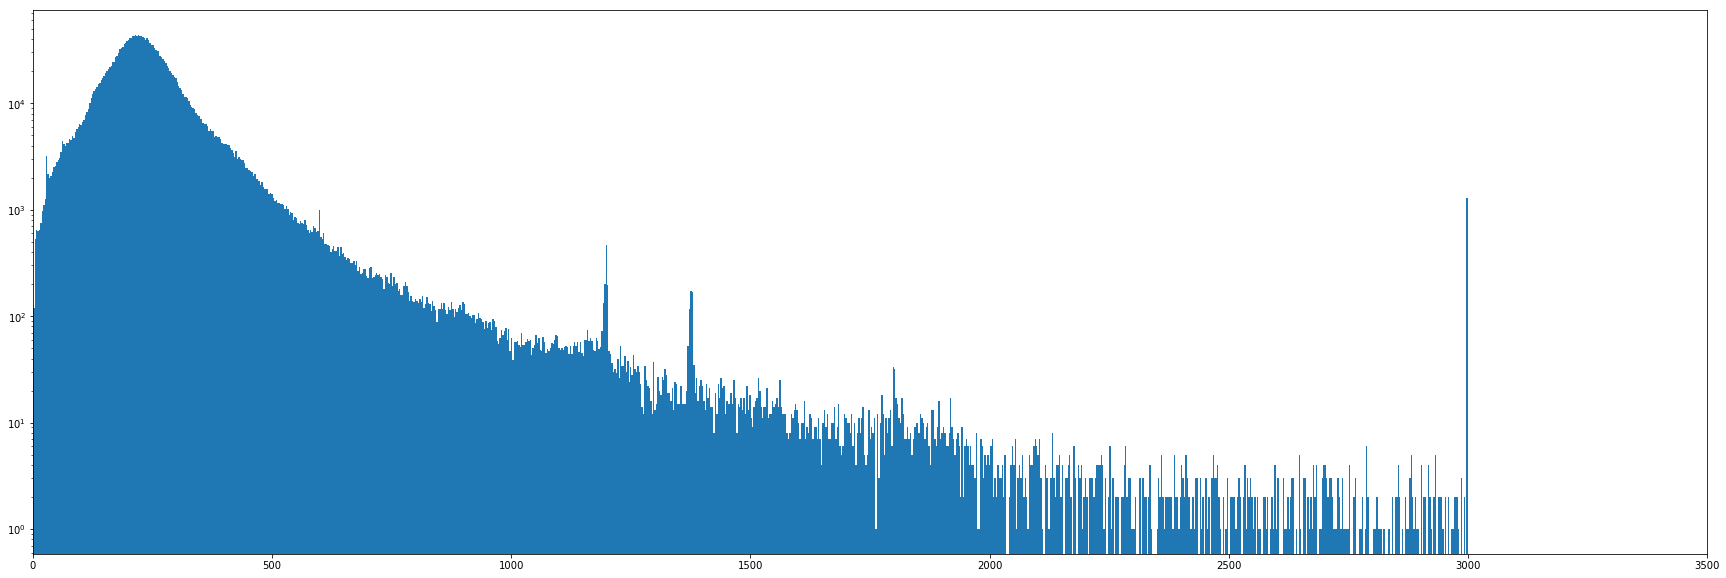

In [12]:
plt.figure(figsize=(30, 10))
plt.yscale('log')
plt.hist(song_lengths.clip(0, 3000), bins=1000)
plt.xlim(0, 3500)
plt.show()

Fortunately, we have only 11 languages to deal with!

In [13]:
languages = songs.groupby('language').size()

In [14]:
languages

language
-1.0      639467
 3.0      106295
 10.0      15482
 17.0      92518
 24.0      41744
 31.0      39201
 38.0       2385
 45.0      14435
 52.0    1336694
 59.0       8098
dtype: int64

It looks like language==-1 are missing/unknown values. Indeed, if we look at the types of songs below, we see no common language among those with language id -1

In [60]:
songs[songs['language']==-1].head(20)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
12,fAZLdfQaLG76a6Ei4alt1eSjBM9rshQkiQEC6+n+y08=,180871,726,Littlesong,Michael William Balfe,NaN,-1.0
18,JcHIgDP5ivyqYIn7RxfXM13eWwOzcoxkWosSauz6RbU=,374027,726,White Noise,NaN,NaN,-1.0
28,+dOlHQGlsiHPbG1cMYsoFVsAi05YgsGfeEzsdS16yec=,368441,1609,Marvin Gaye & Kygo,Marvin Gaye| Odell Brown| David Ritz,Marvin Gaye| Odell Brown| David Ritz,-1.0
44,/pNJtPeT5RixL9cwAScQ83XG6lzNjQbxXdz9Bxm3UCk=,954851,873,蘇曼竹巴仁波切,公版,公版,-1.0
54,vLLKr+iN+vepbTD6W2kDXHvuqmGiXGdXRRHLjRp0pCQ=,300257,873,原力歌手,王苒馨,公版,-1.0
61,m86acAJ3Bj2fL+4vbwWPHmOlrxF1Bk9F34/6kj5JpjI=,293511,786|947,寶寶水晶音樂,NaN,NaN,-1.0
81,vBICG1rGbS2Cfj+/bAQFb+5IYVKhdLOGcnN3nlel728=,38359,726,50 Best Children's Classics,NaN,NaN,-1.0
83,I/La/znX36CnxSjgTQZnz5G/q9Xf02TMY5oPnRkzSjE=,270048,2122,Kenny G,NaN,NaN,-1.0
89,oO+abG+WVeSmJlb9LLUZlg9GiCFuZ+AsMEGVlR33BFg=,330884,786|947,李欣芸 (CinCin Lee),許嫚烜,NaN,-1.0
93,skCaG6fywLmpJaTNeqL89sis3vUydYzd+HLnBy9DsiE=,199645,1609|2107,David Guetta,David Guetta| Giorgio H. Tuinfort,NaN,-1.0


Not so if we look into some other language id, for example 52, which is possibly english, since it has a large count

In [61]:
songs[songs['language']==52].head(20)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0
14,an6EdIr+Z+KbqIVQiXn5PKkcXncefQ7hhWONseRuub4=,282697,359,Coldplay,Chris Martin| Guy Berryman| Jonny Buckland| Mi...,NaN,52.0
15,J2MFmy8iF94mExWfRWE3KxsMZB+ZIedV5liqZoSrERQ=,221518,359,Maggie Rogers,Maggie Rogers| Nicholas Das,NaN,52.0
20,IV8kTOBKcUoO4fINEi+VTYzr7TdyM/kin+gapgzygco=,228993,465,Katy Perry,Katy Perry| Max Martin| Lukasz Gottwald| Henry...,NaN,52.0
24,bTM25FJNlCHnltU0hhQDFAzdnOYsobmfCwwAnN1K2a8=,430080,1609,Danny Marquez & Ferry B,NaN,NaN,52.0
27,+M/yM08pYwOznHRvf9Aj95A9M85wn4/jsTX0ye1KR2c=,281054,139,The Weeknd,Abel Tesfaye| Timothy Mckenzie| Carlo Montagnese,NaN,52.0
33,uHSNhmCD4V7IglA225OelhM+HreWIjFdE+nf3NicFOU=,394739,1609,Pet Shop Boys,NaN,NaN,52.0
35,NV9HhUzyK50tGvxb3w0PdZoaw3Ypp86XDmmMr0vgFdg=,262749,139,John Legend,John Stephens,John Stephens,52.0
39,OLnB6amnCTMEz5KxrV7pdkXJWB+fnMoWVJSzv2AlBLk=,236355,465,Westlife,Bettis| Hammond,Bettis| Hammond,52.0


We spot checked a few isrc numbers in songs_meta table, however it appears that these numbers are not very reliable. I looked up a few isrc databases and some of them recognized some of the id's others didn't.

In [17]:
songs_meta.name.sort_values(inplace=False).unique()[:20]

array(['  1. Boom (Dimitri Vangelis & Wyman Remix (Radio Edit))',
       " 'Che farò' from Orfeo ed Euridice (b)",
       ' (Don’t Call Me) Mrs Christmas',
       ' (Je Ne Veux Plus Etre) Ta Reine (Jame Lewis Monster Phunk Mix)(Hanna Hais)',
       ' ...und ganz doll a cappella (A-Cappella-Version) ',
       ' 24karats –type S-(與放浪兄弟EXILE、DOBELMAN合作超跳嘻哈單曲)',
       ' 8 Humoresques Humoresque in G Major| Op. 101',
       ' A Foreboding Sky',
       ' A Gentle Dissolve (Shawn Lee Ping Pong Orchestra Remix)(Thievery Corporation)',
       ' A Miles ', ' A-CHA',
       ' About Love (Bearweasels Linear Dub) (Bearweasels Linear Dub) ',
       ' Adicto ', ' Andromeda (Original Mix)', ' Angel Of Mine - La',
       ' Apollo Road (Patric La Funk Remix)',
       ' Asia River (2010 New Edit) (DJ Code) ',
       ' Ayla (Original DJ Taucher Mix)', ' Back From Where I Started',
       ' Bad Bad You| Bad Bad Me '], dtype=object)

Again, with the song names, I see a lot of scopre for normalization exists. For example many of them have a leading space character. There are multiple versions of the same song. However, can we club different versions of the same song? Won't they correspond to slightly different style of music?

# User Statistics

First, we need to check how many users are there each in train and test, and how many users in test have a history in the training dataset.

In [18]:
len(set(train.msno.values)), len(set(test.msno.values)), len(set(train.msno.values) & set(test.msno.values))

(30755, 25131, 21483)

We can see that there are about 4k users for which we have absolutely no history. For such users the guess has to be made entirely based on the song's' history. (cold start!)

Lets now look at the stats of the demographic information of the users provided.

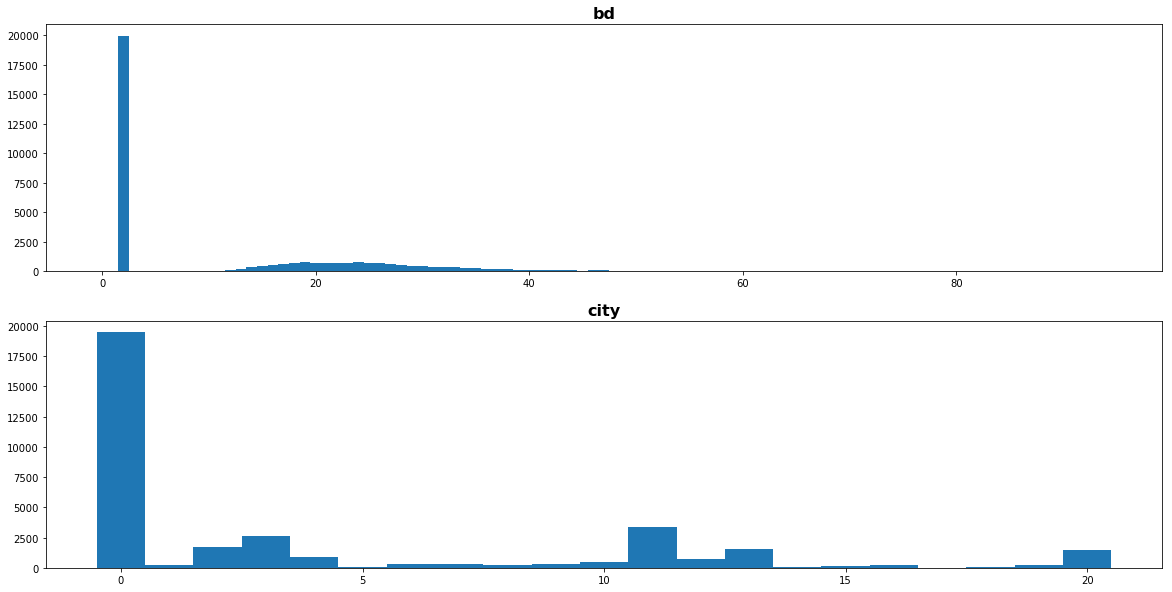

In [19]:
def plot_distribution_users(col, ax):
    groupby = users.groupby(col)[col].count()
    labels= groupby.keys()
    values = groupby.values
    n = len(values)
    ax.bar(range(n), values, width=1)
    ax.set_title(col, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    
fg, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_distribution_users('bd', axes[0])
plot_distribution_users('city', axes[1])

The user information is a complete mess! We see that the age of most of the users is '0'! There are several values which are less than 0 too. The distirbution of cities is quiet skewed, most of the users come from one particular city which is labeled as 0. (Probably a default option).
From the data quality graph, we also observe that the gender dataset has many missing values too. However, for the rest of the dataset, the distribution looks somewhat balanced

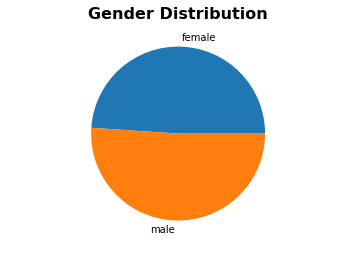

In [20]:
gender_dist = users.groupby('gender')['gender'].count()
plt.axis("equal")
plt.pie(gender_dist.values, labels=gender_dist.keys())
plt.title('Gender Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()

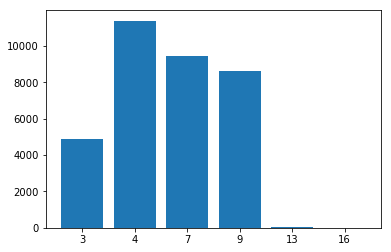

In [21]:
registered_via = users.groupby('registered_via')['registered_via'].count()
plt.bar(range(len(registered_via.keys())), registered_via.values)
_ = plt.xticks(range(len(registered_via.keys())), registered_via.keys())

Since we don't have any meanings attached to the numbers corresponding to "registered_via", not much inference can be drawn. One thing to notice, however, is that "16" and "13" have only a handful of users corresponding to them. In fact, there's only one user who was registered via "16"! Out of curiosity, we try to chase the user to check if there's anything special about them.

In [46]:
users[users.apply(lambda x: x.registered_via==16, axis=1)]

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
15801,RtehpGwMFnKR7Fx5Yyp6UvXOeePpMG9R7TvIqP8IDOE=,1,0,NaN,16,20141025,20141025


In [57]:
train[train.msno == 'RtehpGwMFnKR7Fx5Yyp6UvXOeePpMG9R7TvIqP8IDOE=']

,msno,song_id,source_system_tab,source_screen_name,source_type,target


Nothing, really. In fact the user doesn't even seem to have any histroy of listening to the music.

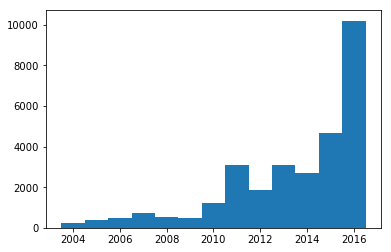

In [42]:
def get_year(row):
    return int(str(row.registration_init_time)[:4])
bins = np.arange(2004, 2004+len(set(registeration_years)))-0.5
_ = plt.hist(registration_years, bins=bins)

We can thus see that most of the users were registered in the last one year.